In [13]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Arial']
matplotlib.rcParams['font.sans-serif'] = ['System Font', 'Verdana', 'Arial']
matplotlib.rcParams['figure.figsize'] = (7, 3)   # Change the size of plots
matplotlib.rcParams['figure.dpi'] = 108

In [15]:
import numpy as np
import numpy.matlib

In [37]:
# Time interval between readings
d = 1.0 / 5000.0
# Stride size of the running window
N = 2500
# Time-series data usually come in chunks
chunk_size = 16
# Have the time-series to be at least 5.0 seconds
K = int(floor(max(10 * N, round(5.0 / d)) / chunk_size) * chunk_size)
# A scaling constant of the clean reference
tics_per_second = 1000000
# Double time in seconds
y = np.array([x for x in range(K)], dtype=np.float64) * d + 7000.0
# Clean reference of tic count
u = np.array([x for x in range(K)], dtype=np.float64) * 1000000 + 19760520000000

# Add noise to x, on the orders of milliseconds
# x = y + 10.0e-3 * (np.random.random(y.shape) - 0.5)
noise = 5.0e-3 * (np.random.random(round(K / chunk_size, )) - 0.5)
x = y + np.kron(noise, np.ones(chunk_size, ))

In [38]:
h_x0 = np.ones(x.shape) * np.nan
h_u0 = np.ones(x.shape) * np.nan
h_dx = np.ones(x.shape) * np.nan
t = np.ones(x.shape) * np.nan
b = 1.0 / N
a = 1.0 - b

# Block size
M = 16

for i in range(2, len(x)):
    if i < N:
        dx_du = (x[i] - x[0]) / (u[i] - u[0])
    else:
        dx_du = (x[i] - x[i - N]) / (u[i] - u[i - N])
    if i <= M:
        x0 = x[i]
        u0 = (u[i] - u[0]) / i + u[0]
        dx = a * (x[i - 1] - x[0]) / (u[i - 1] - u[0]) + b * dx_du
    else:
        x0 = a * x0 + b * x[i]
        u0 = a * u0 + b * u[i]
        dx = a * dx + b * dx_du
    t[i] = x0 + dx * (u[i] - u0)
    # Keep a history
    h_dx[i] = dx
    h_x0[i] = x0
    h_u0[i] = u0
    
# For plotting, set the beginning t values to be nice
t[1] = t[2] - d
t[0] = t[1] - d

Original jitter = 0.514185721046  ms
Smoothed jitter = 0.00129495601662  ms


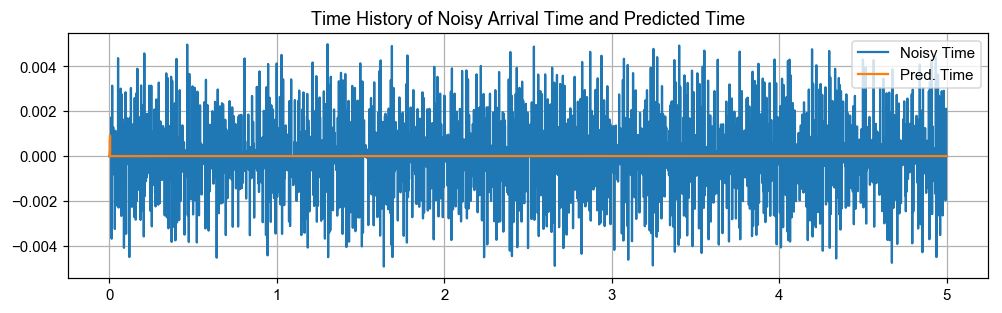

In [39]:
fig = matplotlib.pyplot.figure(figsize=(11, 3))
h1 = matplotlib.pyplot.plot(y[1:] - y[0], np.diff(x) - d, label='Noisy Time')
h2 = matplotlib.pyplot.plot(y[2:] - y[0], np.diff(t)[1:] - d, label='Pred. Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.legend()
matplotlib.pyplot.title('Time History of Noisy Arrival Time and Predicted Time')
print('Original jitter =', np.std(np.diff(x[-N:])) * 1.0e3, ' ms')
print('Smoothed jitter =', np.std(np.diff(t[-N:])) * 1.0e3, ' ms')

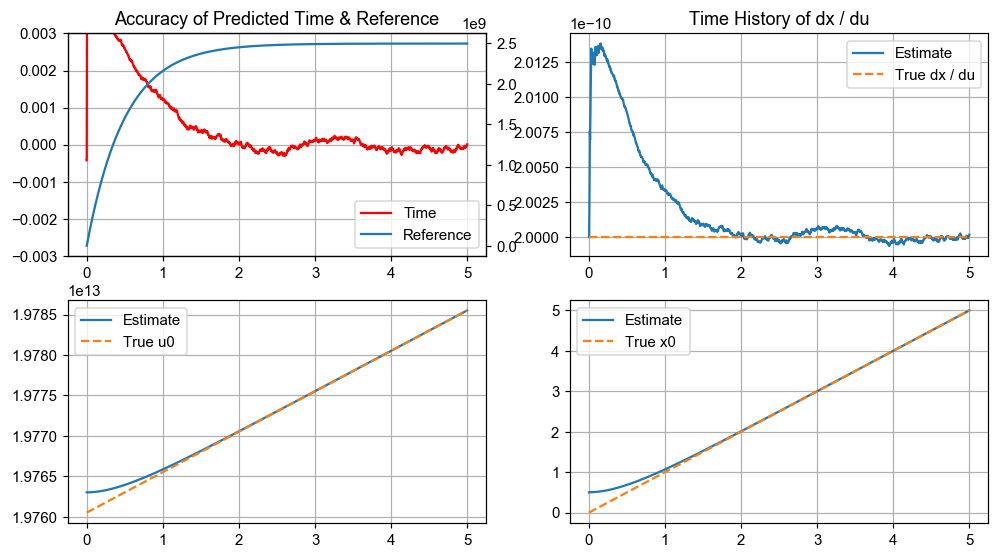

In [40]:
fig = matplotlib.pyplot.figure(figsize=(11, 6))

ax1 = fig.add_subplot(221)
h1 = ax1.plot(y - y[0], t - y, '-r')
ax1.grid()
matplotlib.pyplot.ylim([-3.0e-3, 3.0e-3])
ax1b = ax1.twinx()
h2 = ax1b.plot(y - y[0], u - h_u0)
ax1b.legend(h1 + h2, ['Time', 'Reference'], loc=4)
matplotlib.pyplot.title('Accuracy of Predicted Time & Reference')

ax2 = fig.add_subplot(222)
ax2.plot(y - y[0], h_dx, label='Estimate')
ax2.plot([0, len(x) * d], np.array([1.0, 1.0]) * 1.0e-6 * d, '--', label='True dx / du')
ax2.grid()
ax2.legend()
matplotlib.pyplot.title('Time History of dx / du')

ax3 = fig.add_subplot(223)
h31 = ax3.plot(y - y[0], h_u0 + tics_per_second * N)
h32 = ax3.plot([0, K * d], [u[0], u[-1]], '--')
ax3.grid()
ax3.legend(h31 + h32, ['Estimate', 'True u0'])

ax4 = fig.add_subplot(224)
h41 = ax4.plot(y - y[0], h_x0 - 7000.0 + d * N)
h42 = ax4.plot([0, K * d], [0, K * d], '--')
ax4.grid()
ax4.legend(h41 + h42, ['Estimate', 'True x0'])